# All Library Functions
## Purpose
In this example we will demonstrate how to:
   - Build a Coreset tree on a train dataset.
   - Adding to the tree additional data through partial_build
   - Update samples' labels
   - Update samples' features
   - Remove samples
   - Compare the model trained on the Coreset with the model trained on the full dataset

In this example we'll be using the well-known Covertype Dataset (https://archive.ics.uci.edu/ml/datasets/covertype).

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import datetime
import random
from time import time

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from dataheroes import CoresetTreeServiceLG

## Prepare datasets

In [3]:
# Load Covertype dataset as a pandas data frame.
# In the output data frame all columns are features beside the last column.
# The last column (Cover_Type) is the target
df = fetch_covtype(as_frame=True).frame

# Split dataset: test=30%, train=70% (train_1=3/4 of the train dataset, tran_2=1/4 of the train dataset)
train, test = train_test_split(df, test_size=0.3, random_state=42)
train_1, train_2 = train_test_split(train, test_size=1/4, random_state=42)

# Prepare the data directory and set the file names.
data_dir = Path("Data")
data_dir.mkdir(parents=True, exist_ok=True)
train_1_file_path = data_dir / "train_1.csv"
train_2_file_path = data_dir / "train_2.csv"
test_file_path = data_dir / "test.csv"

# Store datasets as CSV.
# We use the data frame index as the unique identifier and define a column for it (index_column)
# Defining an index column is optional. In this example we set it to have a reference to the original dataset.
train_1.to_csv(train_1_file_path, index_label="index_column")
train_2.to_csv(train_2_file_path, index_label="index_column")
test.to_csv(test_file_path, index_label="index_column")

## 1. Build the tree
Run `build_from_file` on the first train file.
It will include ~305K sample. We pass `n_classes` and `n_instances` to help the tree calculate an optimal Coreset size.

In [4]:
# Tell the tree how the data is structured.
# In this example we have an index column, a target column and a property column. 
# Property is a column you can filter on, but it isn't taken into account when building 
# the coreset or training the model. 
# All other columns are features.

start_time = time()
data_params = {
    'target': {'name': 'Cover_Type'},
    'index': {'name': 'index_column'}
}
# Initialize the service and build the tree.
# The tree uses the local file system to store its data.
# After this step you will have a new directory .dataheroes_cache
service_obj = CoresetTreeServiceLG(data_params=data_params,
                                   optimized_for=['training', 'cleaning'],
                                   n_classes=7,
                                   n_instances=305_000,
                                  )
service_obj.build_from_file(train_1_file_path)

print(f"Coreset Build time (sec) {round(time()-start_time, 2)}")

Coreset Build time (sec) 22.76


## 2. Plot the tree

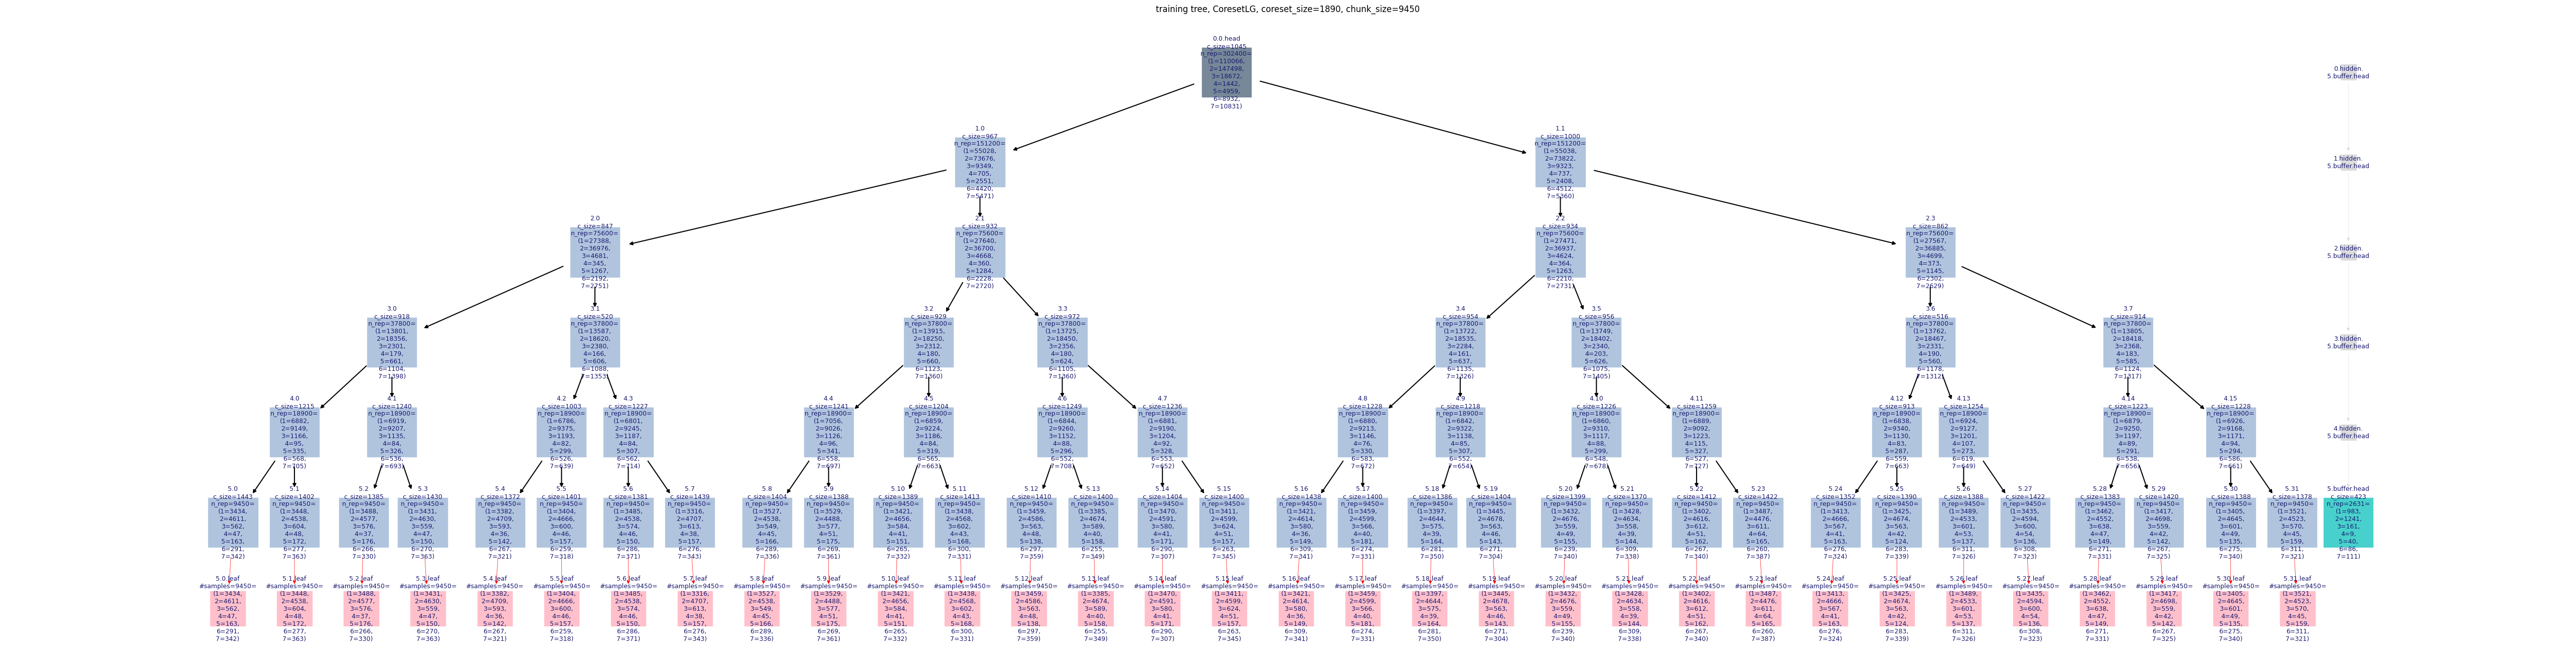

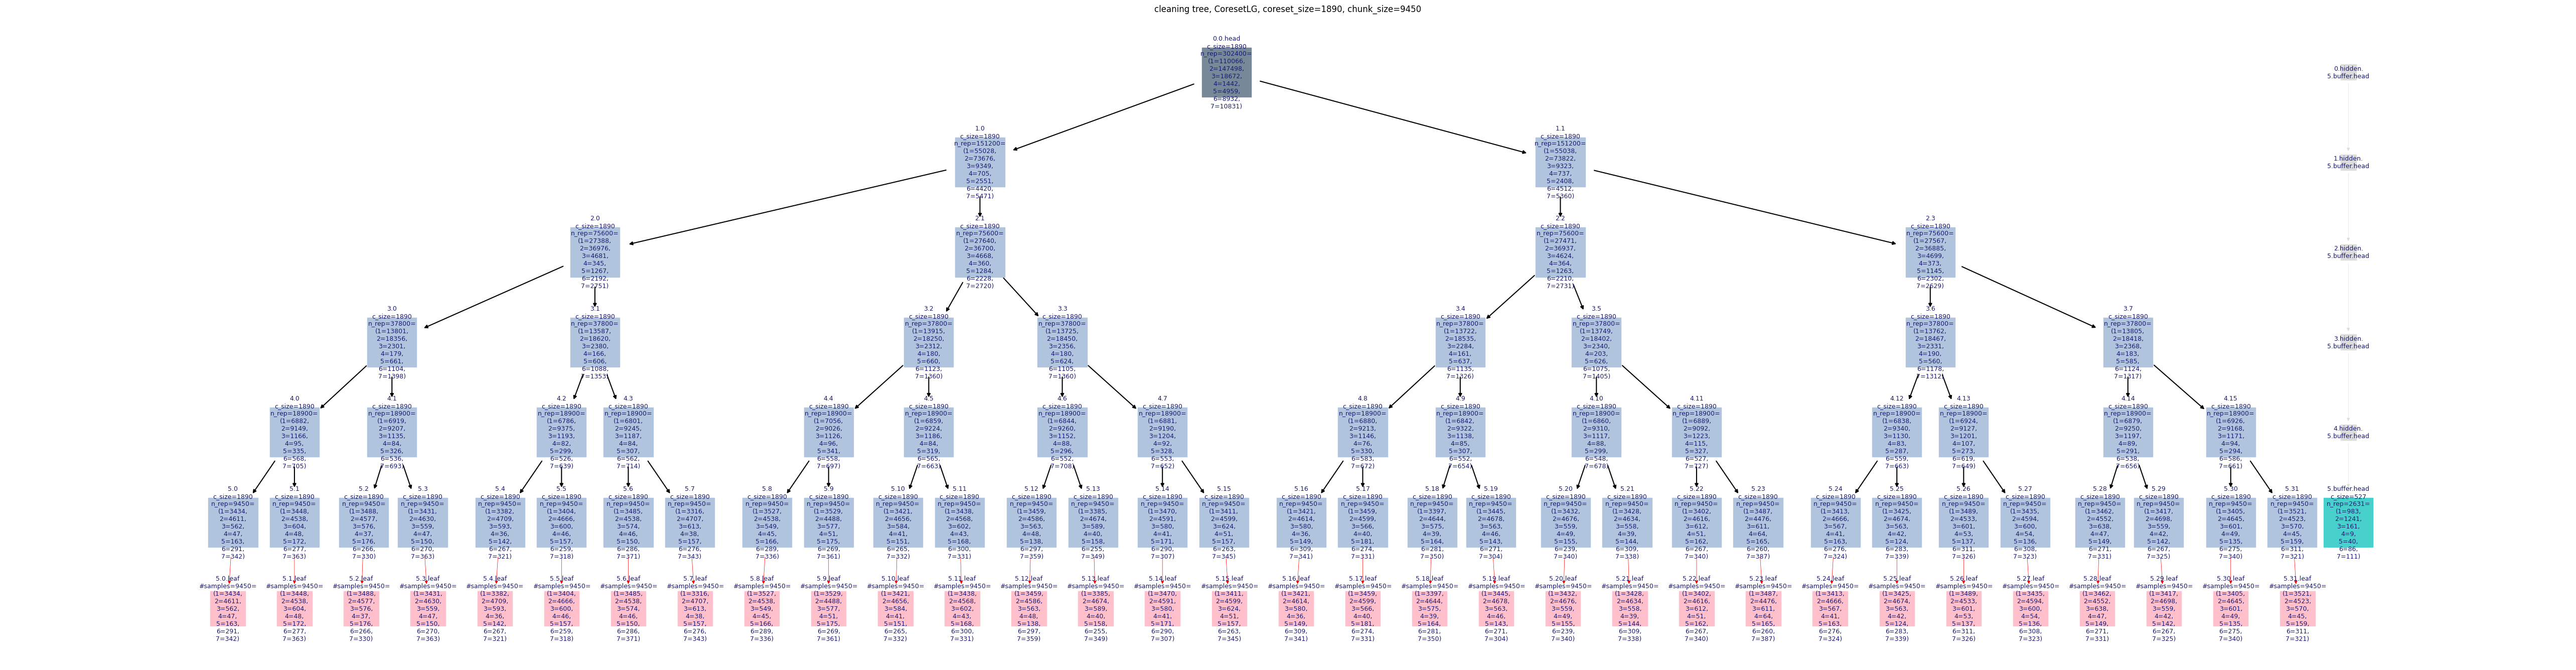

In [5]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
plot_paths = service_obj.plot(output_dir)

## 3. Get coreset from the tree, train a model based on it

In [6]:
# Ignore convergence warnings for logistic regression
#from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Get the top level coreset (~2K samples with weights)
start_time = time()
coreset = service_obj.get_coreset()
indices, X, y = coreset['data']
w = coreset['w']
# Train a logistic regression model on the coreset.
coreset_model = LogisticRegression(max_iter=250).fit(X, y, sample_weight=w)
n_samples_coreset = len(y)
print(f"Coreset train time (sec) {round(time()-start_time, 2)}")

Coreset train time (sec) 0.63


## 4.1. Train a model on the full dataset for comparison
We use the same part of the dataset that was used for building the tree

In [7]:
X = train_1.iloc[:, 0:-1].to_numpy() 
y = train_1.iloc[:, -1].to_numpy()

start_time = time()
full_dataset_model = LogisticRegression(max_iter=250).fit(X, y)
n_samples_full = len(y)
print(f"Full dataset train time (sec) {round(time()-start_time, 2)}")

Full dataset train time (sec) 35.67


### 4.2. Compare models quality
Test both coreset and full model on test dataset and compare their AUC scores

In [8]:
# Read test dataset from file
X_test = test.iloc[:, 0:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy()

# Evaluate model
coreset_score = roc_auc_score(y_test, coreset_model.predict_proba(X_test), multi_class='ovr')
full_dataset_score = roc_auc_score(y_test, full_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Coreset AUC score ({n_samples_coreset:,} samples): {round(coreset_score,3)}")
print(f"Full dataset AUC score ({n_samples_full:,} samples): {round(full_dataset_score,3)}")

Coreset AUC score (1,468 samples): 0.837
Full dataset AUC score (305,031 samples): 0.846


## 5.1. Save the tree for later use

In [9]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_1_coreset_tree'
save_path = service_obj.save(out_dir, save_tree_name, override=True)

### 5.2. Load the saved tree

In [10]:
service_obj = CoresetTreeServiceLG.load(out_dir, save_tree_name)

## 6. Partial build
Add the second train dataset to the tree using `partial_build_from_file`.

In [11]:
start_time = time()
service_obj.partial_build_from_file(train_2_file_path)
print(f"Coreset partial build time (sec) {round(time()-start_time, 2)}")

Coreset partial build time (sec) 6.43


## 7. Get Cleaning Samples

Call `get_cleaning_samples` for a certain class (the biggest) for 100 samples to identify mislabeled samples.

In [12]:
# There are 7 classes, we choose the biggest one, that is 2
start_time = time()
biggest_class = 2
number_important_samples = 100
important_samples = service_obj.get_cleaning_samples(class_size={biggest_class: number_important_samples})
print(f"Coreset get cleaning samples time (sec) {round(time()-start_time, 2)}")

Coreset get cleaning samples time (sec) 0.27


## 8. Update targets
Call `update_targets` for some returned samples above. To further compare the models' result (tree vs. full dataset) we also update the targets in the same way, for the same samples on full dataset.

In [13]:
# take first 5 samples for update (0..4)
indexes_for_update_targets = np.arange(0,5)
# updating target with different values (not equal 2)
y_new = [1, 3, 4, 7, 7]
# update selected samples on the coreset tree
start_time = time()
service_obj.update_targets(important_samples['idx'][indexes_for_update_targets], y_new)
print(f"Coreset update targets time (sec) {round(time()-start_time, 2)}")

# Same update on full dataset
train.loc[important_samples['idx'][indexes_for_update_targets], 'Cover_Type'] = y_new

Coreset update targets time (sec) 0.23


## 9. Update features
Call `update_features` for some returned samples above (different ones than 8).

In [14]:
# take next 5 samples for update (5..9)
indexes_for_update_features = np.arange(5,10)
X_new = important_samples['X'][indexes_for_update_features]
# modify X, as a simple example - set all binary fields = 1
for sample in X_new:
    sample[sample == 0] = 1
# update selected samples on the coreset tree
start_time = time()
service_obj.update_features(important_samples['idx'][indexes_for_update_features], X_new)
print(f"Coreset update features time (sec) {round(time()-start_time, 2)}")

# same features updated on full dataset
train.loc[important_samples['idx'][indexes_for_update_features], train.columns[0:-1]] = X_new

Coreset update features time (sec) 7.2


## 10. Remove samples
Call `remove_samples` for some returned samples above (different ones than 8 and 9).

In [15]:
# take next 5 samples for remove (10..14)
indexes_for_remove = np.arange(10,15)
# remove selected samples from the coreset tree
start_time = time()
service_obj.remove_samples(important_samples['idx'][indexes_for_remove])
print(f"Coreset remove samples time (sec) {round(time()-start_time, 2)}")

# remove same samples from full dataset
train = train.drop(train.loc[important_samples['idx'][indexes_for_remove]].index)

Coreset remove samples time (sec) 4.95


## 11. Fit on the tree
Run `fit` directly on the tree

In [16]:
start_time = time()
service_obj.fit(max_iter=250)
n_samples_coreset = len(service_obj.get_coreset()['w'])
print(f"Coreset fit time (sec) {round(time()-start_time, 2)}")

Coreset fit time (sec) 1.89


## 12.1 Train model of entire dataset
Train model of entire train dataset to compare AUC score with coreset

In [17]:
X = train.iloc[:, 0:-1].to_numpy()
y = train.iloc[:, -1].to_numpy()

start_time = time()
full_updated_dataset_model = LogisticRegression(max_iter=250).fit(X, y)
n_samples_full = len(y)
print(f"Full dataset fit time (sec) {round(time()-start_time, 2)}")

Full dataset fit time (sec) 44.09


### 12.2 Compare models quality

In [18]:
final_tree_lg_score = roc_auc_score(y_test, service_obj.predict_proba(X_test), multi_class='ovr')
full_updated_dataset_score = roc_auc_score(y_test, full_updated_dataset_model.predict_proba(X_test), multi_class='ovr')

print(f"Updated Coreset AUC score ({n_samples_coreset:,} samples): {round(final_tree_lg_score, 3)}")
print(f"Full updated dataset AUC score ({n_samples_full:,} samples): {round(full_updated_dataset_score, 3)}")

Updated Coreset AUC score (5,805 samples): 0.858
Full updated dataset AUC score (406,703 samples): 0.846
